# MRI Volume Registration using Affine Transforms and Wavelet Scattering
EE 678, Group 22


### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from kymatio import Scattering2D
import nibabel as nib
import matplotlib.pyplot as plt
import SimpleITK as sitk

### Loading the data files

In [2]:
# Load the NIfTI file
month1 = nib.load('Khalil_1_11052019.nii')
month1_data = month1.get_fdata()
month1_data = month1_data/np.max(month1_data)

month3 = nib.load('Khalil_3_24082019.nii')
month3_data = month3.get_fdata()
month3_data = month3_data/np.max(month3_data)

pad = 27
pad_data =np.zeros((month1_data.shape[0],month1_data.shape[1],pad))
month3_data_trimming = month3_data[0:month1_data.shape[0],0:month1_data.shape[1],pad:month1_data.shape[2]]
month3_data = np.concatenate((month3_data_trimming, pad_data), axis=2)

# Load the bone masks (from k-means clustering)
bone_mask_month_1 = nib.load('./saved-data/khalil/bone_mask_month_1.nii').get_fdata()
bone_mask_month_3 = nib.load('./saved-data/khalil/bone_mask_month_3.nii').get_fdata()

### Visualize a slice

In [3]:
# Set a global index for slicing
index =200

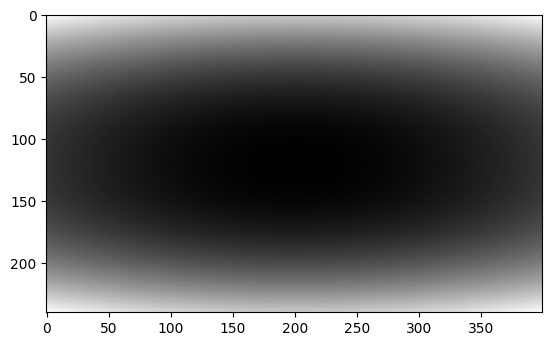

In [4]:
# create a 240x400 image with center (120x200) = black and edges = white and gradient
filter = np.zeros((240, 400))
# create gradient such that ends of the matrix are 1 while center is 0
for i in range(240):
    for j in range(400):
        filter[i, j] = (np.abs(i-120)**2.5 + np.abs(j-200)**2)
filter = filter - np.min(filter)
filter = filter / np.max(filter)
plt.imshow(filter, cmap='gray')

In [5]:
# Apply the filter to the bone mask for each slice
bone_mask_month_1_filtered = np.zeros((240, 400, 400))
bone_mask_month_3_filtered = np.zeros((240, 400, 400))
for i in range(400):
    bone_mask_month_1_filtered[:, :, i] = bone_mask_month_1[:, :, i] * filter
    bone_mask_month_3_filtered[:, :, i] = bone_mask_month_3[:, :, i] * filter
    

In [6]:
# Obtain masked bone images
masked_bone_month_1 = month1_data * bone_mask_month_1
masked_bone_month_3 = month3_data * bone_mask_month_3

Text(0.5, 1.0, 'Bones Month 3')

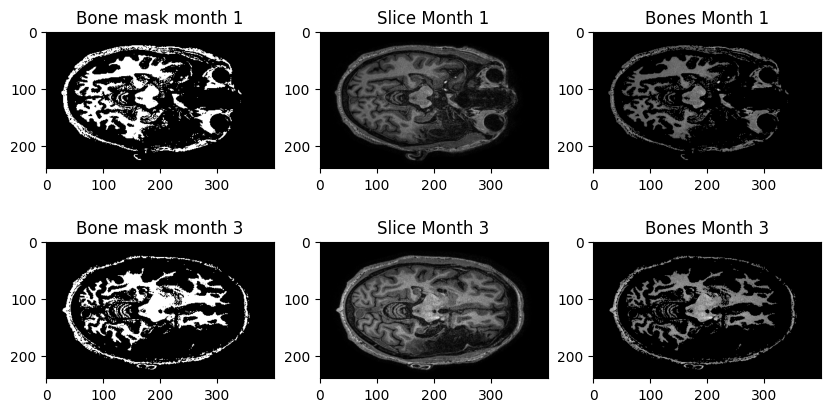

In [7]:
fig,ax = plt.subplots(2,3, figsize=(10,5))
ax[0][0].imshow(bone_mask_month_1[:,:,index], cmap='gray')
ax[0][0].set_title('Bone mask month 1')
ax[1][0].imshow(bone_mask_month_3[:,:,index], cmap='gray')
ax[1][0].set_title('Bone mask month 3')
ax[0][1].imshow(month1_data[:,:,index], cmap='gray')
ax[0][1].set_title('Slice Month 1')
ax[1][1].imshow(month3_data[:,:,index], cmap='gray')
ax[1][1].set_title('Slice Month 3')
ax[0][2].imshow(masked_bone_month_1[:,:,index], cmap='gray')
ax[0][2].set_title('Bones Month 1')
ax[1][2].imshow(masked_bone_month_3[:,:,index], cmap='gray')
ax[1][2].set_title('Bones Month 3')

## Rigid Registration

In [8]:
# Function to convert numpy array to SimpleITK image
def numpy_to_sitk(image_np):
    return sitk.GetImageFromArray(image_np)

# Function to convert SimpleITK image to numpy array
def sitk_to_numpy(image_sitk):
    return sitk.GetArrayFromImage(image_sitk)

In [9]:
"""
reference_image = numpy_to_sitk(masked_bone_month_1)
moving_image = numpy_to_sitk(masked_bone_month_3)

# Initialize the registration method
registration_method = sitk.ImageRegistrationMethod()

# Set metric, optimizer, and interpolator for the registration
registration_method.SetMetricAsMeanSquares()
registration_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=1000)
registration_method.SetInterpolator(sitk.sitkLinear)

# Set the initial transformation as a rigid transformation
initial_transform = sitk.CenteredTransformInitializer(reference_image,
                                                      moving_image,
                                                      sitk.Euler3DTransform(),
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

registration_method.SetInitialTransform(initial_transform, inPlace=False)
final_transform = registration_method.Execute(reference_image, moving_image)

# Apply the transformation to a different 3D matrix
new_moving_np = month3_data
new_reference_np = month1_data
new_reference_image = numpy_to_sitk(new_reference_np)
new_moving_image = numpy_to_sitk(new_moving_np)
transformed_image = sitk.Resample(new_moving_image, reference_image, final_transform, sitk.sitkLinear, 0.0, new_moving_image.GetPixelID())

# Convert the transformed image back to a numpy array
transformed_np = sitk_to_numpy(transformed_image)
registered_month_3 = transformed_np

# transformed_np now contains the transformed 3D matrix of the new input
plt.imshow(transformed_np[:,:,index], cmap='gray')

# Save the transformation to a file (optional)
# sitk.WriteTransform(final_transform, "rigid_transform.tfm")

# If you want to load and apply the saved transform
# loaded_transform = sitk.ReadTransform("rigid_transform.tfm")
# transformed_image_with_loaded_transform = sitk.Resample(new_moving_image, reference_image, loaded_transform, sitk.sitkLinear, 0.0, new_moving_image.GetPixelID())
# transformed_np_with_loaded_transform = sitk_to_numpy(transformed_image_with_loaded_transform)
"""

'\nreference_image = numpy_to_sitk(masked_bone_month_1)\nmoving_image = numpy_to_sitk(masked_bone_month_3)\n\n# Initialize the registration method\nregistration_method = sitk.ImageRegistrationMethod()\n\n# Set metric, optimizer, and interpolator for the registration\nregistration_method.SetMetricAsMeanSquares()\nregistration_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=1000)\nregistration_method.SetInterpolator(sitk.sitkLinear)\n\n# Set the initial transformation as a rigid transformation\ninitial_transform = sitk.CenteredTransformInitializer(reference_image,\n                                                      moving_image,\n                                                      sitk.Euler3DTransform(),\n                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)\n\nregistration_method.SetInitialTransform(initial_transform, inPlace=False)\nfinal_transform = registration_method.Execute(reference_image, moving_image

## Affine Registration

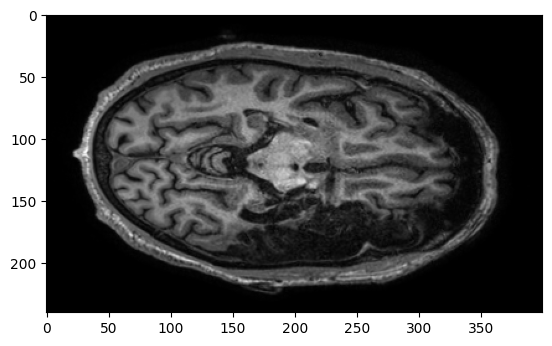

In [10]:
reference_image = numpy_to_sitk(masked_bone_month_1)
moving_image = numpy_to_sitk(masked_bone_month_3)

reference_image = numpy_to_sitk(masked_bone_month_1)
moving_image = numpy_to_sitk(masked_bone_month_3)

# Initialize the registration method
registration_method = sitk.ImageRegistrationMethod()

# Set metric, optimizer, and interpolator for the registration
registration_method.SetMetricAsMeanSquares()
registration_method.SetOptimizerAsGradientDescent(learningRate=1, numberOfIterations=1000)
registration_method.SetInterpolator(sitk.sitkLinear)

# Set the initial transformation as a rigid transformation
initial_transform = sitk.CenteredTransformInitializer(reference_image,
                                                      moving_image,
                                                      sitk.AffineTransform(3),
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Optimizer settings
# registration_method.SetOptimizerAsRegularStepGradientDescent(
#     learningRate=1.0,
#     minStep=1e-4,
#     numberOfIterations=300,
#     gradientMagnitudeTolerance=1e-8
# )

# Interpolator
registration_method.SetInterpolator(sitk.sitkLinear)

final_transform = registration_method.Execute(reference_image, moving_image)

# Apply the transformation to a different 3D matrix
new_moving_np = month3_data
new_reference_np = month1_data
new_reference_image = numpy_to_sitk(new_reference_np)
new_moving_image = numpy_to_sitk(new_moving_np)
transformed_image = sitk.Resample(new_moving_image, reference_image, final_transform, sitk.sitkLinear, 0.0, new_moving_image.GetPixelID())

# Convert the transformed image back to a numpy array
transformed_np = sitk_to_numpy(transformed_image)
registered_month_3 = transformed_np

# transformed_np now contains the transformed 3D matrix of the new input
plt.imshow(transformed_np[:,:,index], cmap='gray')

# Save the transformation to a file (optional)
# sitk.WriteTransform(final_transform, "rigid_transform.tfm")

# If you want to load and apply the saved transform
# loaded_transform = sitk.ReadTransform("rigid_transform.tfm")
# transformed_image_with_loaded_transform = sitk.Resample(new_moving_image, reference_image, loaded_transform, sitk.sitkLinear, 0.0, new_moving_image.GetPixelID())
# transformed_np_with_loaded_transform = sitk_to_numpy(transformed_image_with_loaded_transform)(reference_image, moving_image)

# Apply the transformation to a different 3D matrix
new_moving_np = month3_data
new_reference_np = month1_data
new_reference_image = numpy_to_sitk(new_reference_np)
new_moving_image = numpy_to_sitk(new_moving_np)
transformed_image = sitk.Resample(new_moving_image, reference_image, final_transform, sitk.sitkLinear, 0.0, new_moving_image.GetPixelID())

# Convert the transformed image back to a numpy array
transformed_np = sitk_to_numpy(transformed_image)
registered_month_3 = transformed_np

# transformed_np now contains the transformed 3D matrix of the new input
plt.imshow(transformed_np[:,:,index], cmap='gray')

# Save the transformation to a file (optional)
# sitk.WriteTransform(final_transform, "rigid_transform.tfm")

# If you want to load and apply the saved transform
# loaded_transform = sitk.ReadTransform("rigid_transform.tfm")
# transformed_image_with_loaded_transform = sitk.Resample(new_moving_image, reference_image, loaded_transform, sitk.sitkLinear, 0.0, new_moving_image.GetPixelID())
# transformed_np_with_loaded_transform = sitk_to_numpy(transformed_image_with_loaded_transform)

In [66]:
# Save the transformation to a file (optional)
sitk.WriteTransform(final_transform, "./saved-data/khalil/rigid_transform-khalil.tfm")

# If you want to load and apply the saved transform
# reference_image = numpy_to_sitk(masked_bone_month_1)
# moving_image = numpy_to_sitk(masked_bone_month_3)
# new_moving_np = month3_data
# new_reference_np = month1_data
# new_reference_image = numpy_to_sitk(new_reference_np)
# new_moving_image = numpy_to_sitk(new_moving_np)

# loaded_transform = sitk.ReadTransform("./saved-data/khalil/rigid_transform-khalil.tfm")
# transformed_image_with_loaded_transform = sitk.Resample(new_moving_image, reference_image, loaded_transform, sitk.sitkLinear, 0.0, new_moving_image.GetPixelID())
# transformed_np = sitk_to_numpy(transformed_image_with_loaded_transform)
# registered_month_3 = transformed_np
# final_transform = loaded_transform


Text(0.5, 1.0, 'Registered Month 3')

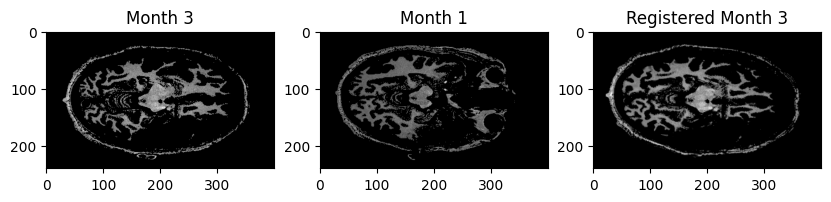

In [12]:
# apply the final transformation to moving image and reference image
transformed_image_bone = sitk.Resample(moving_image, reference_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())
transformed_np_bone = sitk_to_numpy(transformed_image_bone)
fig,ax = plt.subplots(1,3, figsize=(10,5))
ax[0].imshow(masked_bone_month_3[:,:,index], cmap='gray')
ax[0].set_title('Month 3')
ax[1].imshow(masked_bone_month_1[:,:,index], cmap='gray')
ax[1].set_title('Month 1')
ax[2].imshow(transformed_np_bone[:,:,index], cmap='gray')
ax[2].set_title('Registered Month 3')


In [13]:
## Compute correlation between month 1 bone and month 3 bone and month 1 bone and month 3 bone after registration
correlation_before = np.corrcoef(masked_bone_month_1.flatten(), masked_bone_month_3.flatten())
correlation_after = np.corrcoef(masked_bone_month_1.flatten(), transformed_np_bone.flatten())
print("Correlation between Month 1 and Month 3 bones (original):",correlation_before[0,1])
print("Correlation between Month 1 and registered Month 3 bones:",correlation_after[0,1])

Correlation between Month 1 and Month 3 bones (original): 0.2933925486578711
Correlation between Month 1 and registered Month 3 bones: 0.40988411442917594


In [14]:
# computer MSE of bones
mse_before = np.mean((masked_bone_month_1 - masked_bone_month_3)**2)
mse_after = np.mean((masked_bone_month_1 - transformed_np_bone)**2)
print("MSE between Month 1 and Month 3 bones (original):", mse_before)
print("MSE between Month 1 and registered Month 3 bones:", mse_after)

MSE between Month 1 and Month 3 bones (original): 0.007196426495962992
MSE between Month 1 and registered Month 3 bones: 0.005730818793347924


## Registration Improvement Metrics 

Text(0.5, 1.0, 'month 3 transformed to month 1')

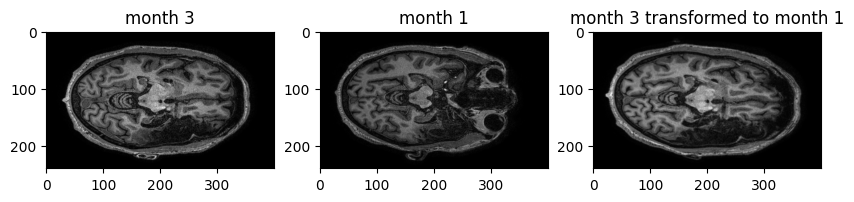

In [15]:
fig,ax = plt.subplots(1,3, figsize=(10,5))

ax[0].imshow(new_moving_np[:,:,index], cmap='gray')
ax[0].set_title('month 3')
ax[1].imshow(new_reference_np[:,:,index], cmap='gray')
ax[1].set_title('month 1')
ax[2].imshow(transformed_np[:,:,index], cmap='gray')
ax[2].set_title('month 3 transformed to month 1')

In [16]:
new_reference_np[:,index,100:].T.shape

(300, 240)

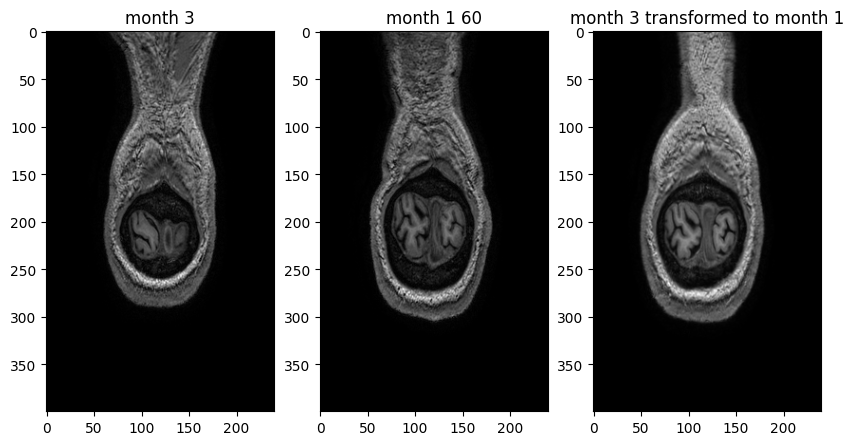

In [17]:
fig,ax = plt.subplots(1,3, figsize=(10,5))
pad_lim = 0

pad = np.zeros((pad_lim,240))
index = 60
padded_month_1 = np.concatenate((pad, new_reference_np[:,index,:-pad_lim].T))
ax[0].imshow(np.concatenate((new_moving_np[:,index,pad_lim:].T, pad)), cmap='gray')
ax[0].set_title('month 3')
ax[1].imshow(new_reference_np[:,index,:].T, cmap='gray')
ax[1].set_title(f'month 1 {index}')
ax[2].imshow(np.concatenate((transformed_np[:,index,pad_lim:].T,pad)), cmap='gray')
ax[2].set_title('month 3 transformed to month 1')
plt.show()

### Cross Correlation

#### Cross Correlation between Month 1, Month 3 and Registered Month 3 volumes

In [18]:
# find correlation bwteen month 1 and registered month 3
correlation_vol_old = np.corrcoef(new_reference_np.flatten(), new_moving_np.flatten())[0,1]
print('Correlation between month 1 and month 3 (original):', correlation_vol_old)
# find correlation bwteen month 1 and month 3
correlation_vol_new = np.corrcoef(new_reference_np.flatten(), registered_month_3.flatten())[0,1]
print('Correlation between month 1 and registered month 3:', correlation_vol_new)

Correlation between month 1 and month 3 (original): 0.6728516640333991
Correlation between month 1 and registered month 3: 0.7325436173430915


In [19]:
cut_brain_month_1 = month1_data[:,:,250:380]
cut_brain_month_3 = month3_data[:,:,250:380]
cut_brain_month_3_registered = registered_month_3[:,:,250:380]
assert (cut_brain_month_1.shape == cut_brain_month_3.shape)
# find correlation bwteen month 1 and registered month 3
correlation_vol_old = np.corrcoef(cut_brain_month_1.flatten(), cut_brain_month_3.flatten())[0,1]
print('Correlation between month 1 and month 3 (original):', correlation_vol_old)
# find correlation bwteen month 1 and month 3
correlation_vol_new = np.corrcoef(cut_brain_month_1.flatten(), cut_brain_month_3_registered.flatten())[0,1]
print('Correlation between month 1 and registered month 3:', correlation_vol_new)

Correlation between month 1 and month 3 (original): 0.6344713008837244
Correlation between month 1 and registered month 3: 0.7613639672239084


Text(0.5, 1.0, 'Month 3 Transformed to Month 1')

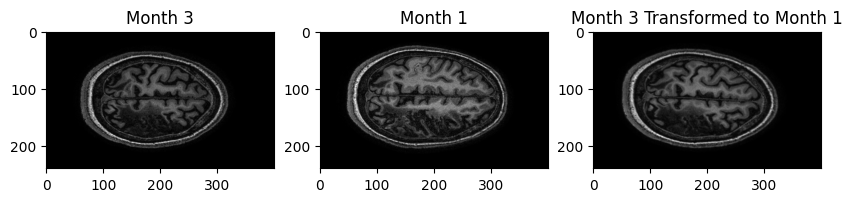

In [20]:
fig,ax = plt.subplots(1,3, figsize=(10,5))
index =40
ax[0].imshow(cut_brain_month_3[:,:,index], cmap='gray')
ax[0].set_title('Month 3')
ax[1].imshow(cut_brain_month_1[:,:,index-7], cmap='gray')
ax[1].set_title('Month 1')
ax[2].imshow(cut_brain_month_3_registered[:,:,index], cmap='gray')
ax[2].set_title('Month 3 Transformed to Month 1')

#### Cross Correlation between slice of Month 1, Month 3 and Registered Month 3 volumes

In [50]:
index=230
month1img = new_reference_np[:,index,:]
month3img = new_moving_np[:,index,:]
registered_month3img = registered_month_3[:,index,:]

# correlation between images
correlation_old = np.corrcoef(month1img.flatten(), month3img.flatten())[0,1]
print('Correlation between month 1 and month 3:', correlation_old)
correlation_new = np.corrcoef(month1img.flatten(), registered_month3img.flatten())[0,1]
print('Correlation between month 1 and registered month 3:', correlation_new)

Correlation between month 1 and month 3: 0.6163750199363083
Correlation between month 1 and registered month 3: 0.6343286565624304


#### Cross Correlation between  wavelet scattering transform coefficients of a slice of Month 1, Month 3 and Registered Month 3 volumes

In [52]:
# Compute the scattering coefficient
scattering = Scattering2D(J=2, shape=month1img.shape)
scattering_month1 = scattering(month1img)
scattering_month3 = scattering(month3img)
scattering_registered_month3 = scattering(registered_month3img)

In [53]:
# compute correlation between scattering coefficients
normalized_scattering_month1 = scattering_month1/np.max(scattering_month1)
normalized_scattering_month3 = scattering_month3/np.max(scattering_month3)
normalized_scattering_registered_month3 = scattering_registered_month3/np.max(scattering_registered_month3)
threshold = 0.2
# thres

correlation_scatter_old = np.corrcoef(normalized_scattering_month1.flatten(), normalized_scattering_month3.flatten())[0,1]
print('Correlation between month 1 and month 3:', correlation_scatter_old)
correlation_scatter_new = np.corrcoef(normalized_scattering_month1.flatten(), normalized_scattering_registered_month3.flatten())[0,1]
print('Correlation between month 1 and registered month 3:', correlation_scatter_new)


Correlation between month 1 and month 3: 0.855932137854279
Correlation between month 1 and registered month 3: 0.8634421333107825


#### Improvement in Correlation

In [54]:
# percentage increase in coorelation
percentage_increase = (correlation_scatter_new - correlation_old)/correlation_old * 100
print('Percentage increase in correlation:', percentage_increase)

Percentage increase in correlation: 40.08389460689116


### Mean Squared Error (MSE)

#### MSE between wavelet scattering transform coefficients 

In [56]:
# compute mean squared error between scattering coefficients
mse_og = np.mean((normalized_scattering_month1 - normalized_scattering_month3)**2)
print('Mean Squared Error between month 1 and month 3:', mse_og)
mse_new = np.mean((normalized_scattering_month1 - normalized_scattering_registered_month3)**2)
print('Mean Squared Error between month 1 and registered month 3:', mse_new)

# % reduction in MSE
mse_reduction = (mse_og - mse_new)/mse_og * 100
print('Percentage reduction in MSE:', mse_reduction,'%')

Mean Squared Error between month 1 and month 3: 0.00040200788792964703
Mean Squared Error between month 1 and registered month 3: 0.0003587794750461376
Percentage reduction in MSE: 10.753125543415845 %


#### MSE between THRESHOLDED wavelet scattering transform coefficients

In [57]:
# thresholded MSE
difference_og = np.abs(normalized_scattering_month1 - normalized_scattering_month3)
thresholded_difference_og = np.where(difference_og > threshold, difference_og, 0)
mse_og = np.mean(thresholded_difference_og**2)
difference_new = np.abs(normalized_scattering_month1 - normalized_scattering_registered_month3)
thresholded_difference_new = np.where(difference_new > threshold, difference_new, 0)
mse_new = np.mean(thresholded_difference_new**2)
print('Mean Squared Error between month 1 and month 3 (thresholded):', mse_og)
print('Mean Squared Error between month 1 and registered month 3 (thresholded):', mse_new)
print('Percentage reduction in MSE (thresholded):', (mse_og - mse_new)/mse_og * 100,'%')

Mean Squared Error between month 1 and month 3 (thresholded): 0.00030416235179776775
Mean Squared Error between month 1 and registered month 3 (thresholded): 0.00027124060542235825
Percentage reduction in MSE (thresholded): 10.823741393641837 %


### Analysis of Boundaries

In [58]:
m1x, m1y, m1z = masked_bone_month_1.shape
m1constraints = {}
for i in range(m1x):
    if np.count_nonzero(masked_bone_month_1[i,:,:]):
        m1constraints['x']=[i]
        break
for i in range(m1x-1,0,-1):
    if np.count_nonzero(masked_bone_month_1[i,:,:]):
        m1constraints['x'].append(i)
        break
for i in range(m1y):
    if np.count_nonzero(masked_bone_month_1[:,i,:]):
        m1constraints['y']=[i]
        break
for i in range(m1y-1,0,-1):
    if np.count_nonzero(masked_bone_month_1[:,i,:]):
        m1constraints['y'].append(i)
        break
for i in range(m1z):
    if np.count_nonzero(masked_bone_month_1[:,:,i]):
        m1constraints['z']=[i]
        break
for i in range(m1z-1,0,-1):
    if np.count_nonzero(masked_bone_month_1[:,:,i]):
        m1constraints['z'].append(i)
        break

In [59]:
m3x, m3y, m3z = masked_bone_month_3.shape
m3constraints = {}
for i in range(m3x):
    if np.count_nonzero(masked_bone_month_3[i,:,:]):
        m3constraints['x']=[i]
        break
for i in range(m3x-1,0,-1):
    if np.count_nonzero(masked_bone_month_3[i,:,:]):
        m3constraints['x'].append(i)
        break
for i in range(m3y):
    if np.count_nonzero(masked_bone_month_3[:,i,:]):
        m3constraints['y']=[i]
        break
for i in range(m3y-1,0,-1):
    if np.count_nonzero(masked_bone_month_3[:,i,:]):
        m3constraints['y'].append(i)
        break
for i in range(m3z):
    if np.count_nonzero(masked_bone_month_3[:,:,i]):
        m3constraints['z']=[i]
        break
for i in range(m3z-1,0,-1):
    if np.count_nonzero(masked_bone_month_3[:,:,i]):
        m3constraints['z'].append(i)
        break

In [60]:
m3_reg_x, m3_reg_y, m3_reg_z = transformed_np_bone.shape
m3_reg_constraints = {}
for i in range(m3_reg_x):
    if np.count_nonzero(transformed_np_bone[i,:,:]):
        m3_reg_constraints['x']=[i]
        break
for i in range(m3_reg_x-1,0,-1):
    if np.count_nonzero(transformed_np_bone[i,:,:]):
        m3_reg_constraints['x'].append(i)
        break
for i in range(m3_reg_y):
    if np.count_nonzero(transformed_np_bone[:,i,:]):
        m3_reg_constraints['y']=[i]
        break
for i in range(m3_reg_y-1,0,-1):
    if np.count_nonzero(transformed_np_bone[:,i,:]):
        m3_reg_constraints['y'].append(i)
        break
for i in range(m3_reg_z):
    if np.count_nonzero(transformed_np_bone[:,:,i]):
        m3_reg_constraints['z']=[i]
        break
for i in range(m3_reg_z-1,0,-1):
    if np.count_nonzero(transformed_np_bone[:,:,i]):
        m3_reg_constraints['z'].append(i)
        break

In [61]:
print("Boundaries of Month 1 Volume:", m1constraints)
print("Bounderies of  Month 3 Volume:", m3constraints)
print("Bounderies of Registered Month 3 Volume:", m3_reg_constraints)

Boundaries of Month 1 Volume: {'x': [0, 225], 'y': [26, 384], 'z': [0, 354]}
Bounderies of  Month 3 Volume: {'x': [15, 226], 'y': [28, 373], 'z': [0, 353]}
Bounderies of Registered Month 3 Volume: {'x': [10, 226], 'y': [21, 389], 'z': [0, 357]}


## Scattering Transform Coeffs

In [62]:
# import guassian filter
from scipy.ndimage import gaussian_filter

Text(0.5, 1.0, 'Boundary')

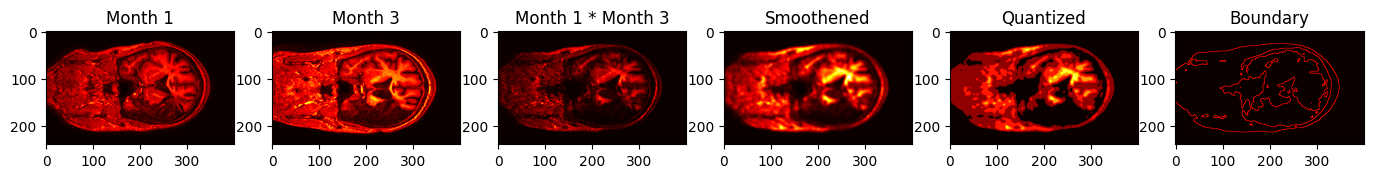

In [63]:
fig,ax = plt.subplots(1,6, figsize=(17,5))
ax[1].imshow(registered_month3img, cmap='hot')
ax[1].set_title('Month 3')
ax[0].imshow(month1img, cmap='hot') # apply median filter
ax[0].set_title('Month 1')
ax[2].imshow(month1img * registered_month3img, cmap='hot')
ax[2].set_title('Month 1 * Month 3')
pdt = month1img * registered_month3img
guassian_pdt = gaussian_filter((10*pdt/np.max(pdt)),sigma=2)
quantized_pdt = np.round(guassian_pdt)
boundary1 = np.abs(np.diff(np.sign(quantized_pdt), axis=1))
boundary1 = np.concatenate((boundary1, boundary1[:,-1].reshape(-1,1)), axis =1)
boundary2 = np.abs(np.diff(np.sign(quantized_pdt), axis=0))
boundary2 = np.concatenate((boundary2, boundary2[-1,:].reshape(1,-1)), axis =0)
boundary = boundary1 + boundary2
ax[3].imshow(guassian_pdt, cmap='hot')
ax[3].set_title('Smoothened')
ax[4].imshow(quantized_pdt, cmap='hot')
ax[4].set_title('Quantized')
ax[5].imshow(boundary, cmap='hot') 
ax[5].set_title('Boundary')

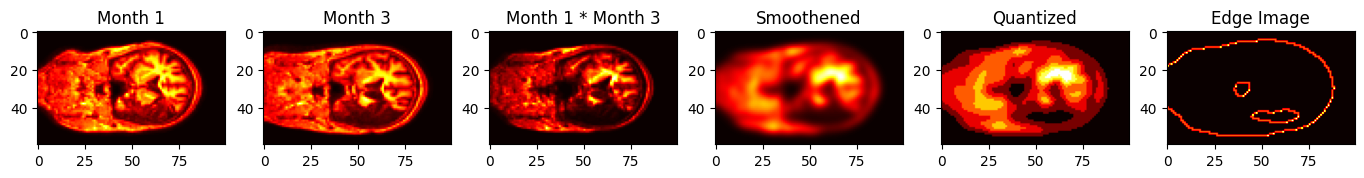

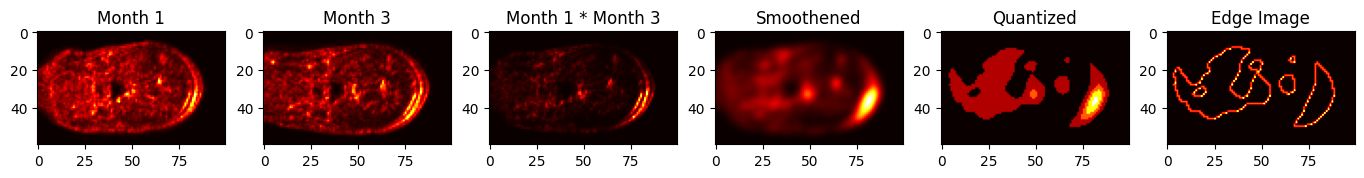

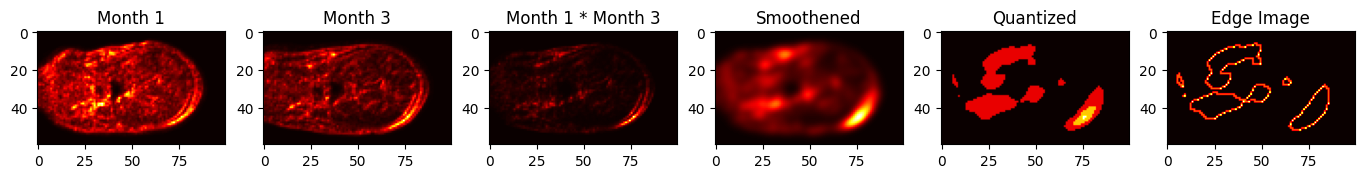

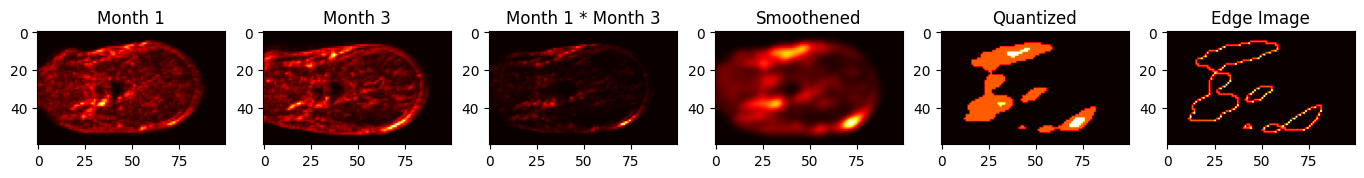

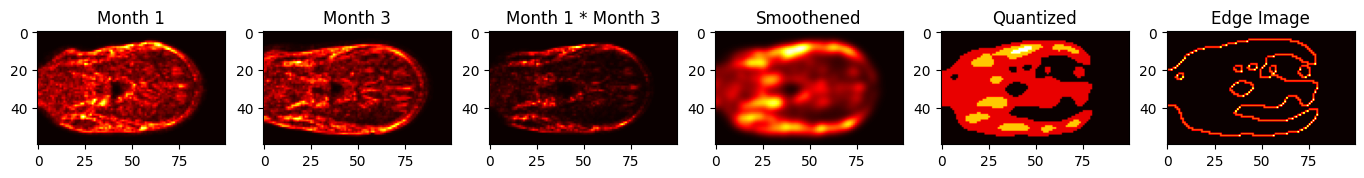

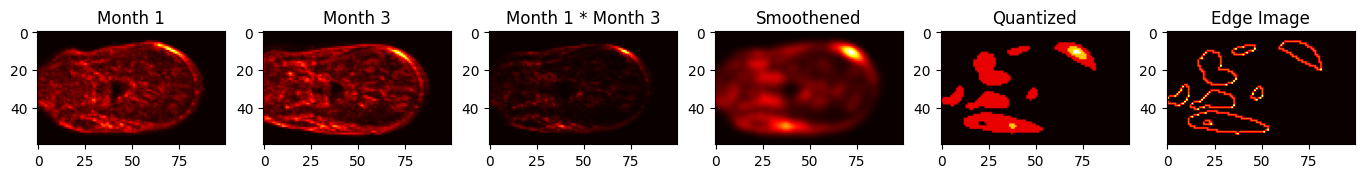

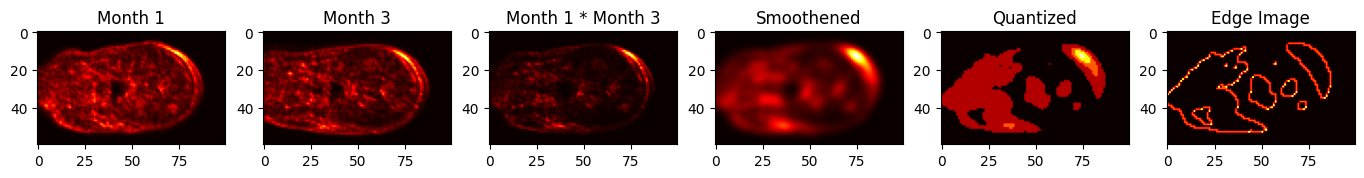

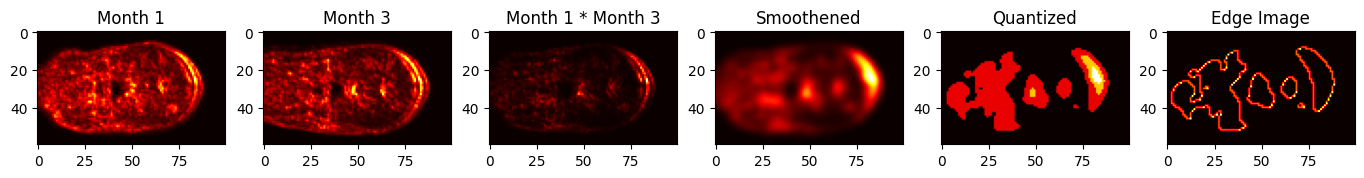

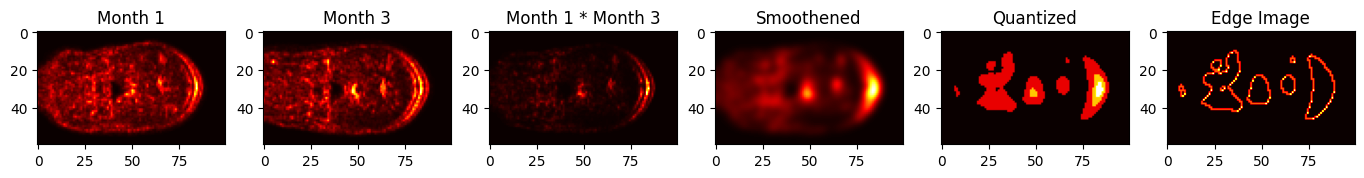

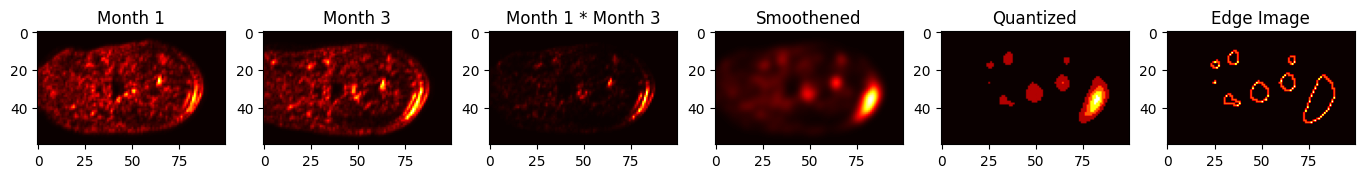

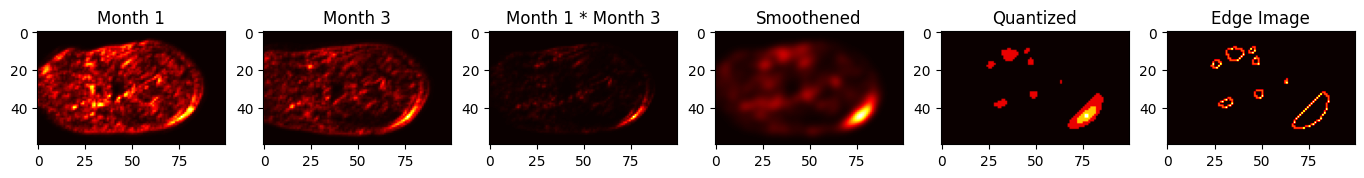

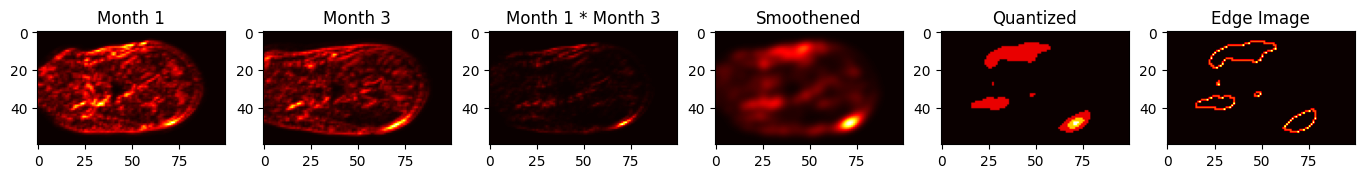

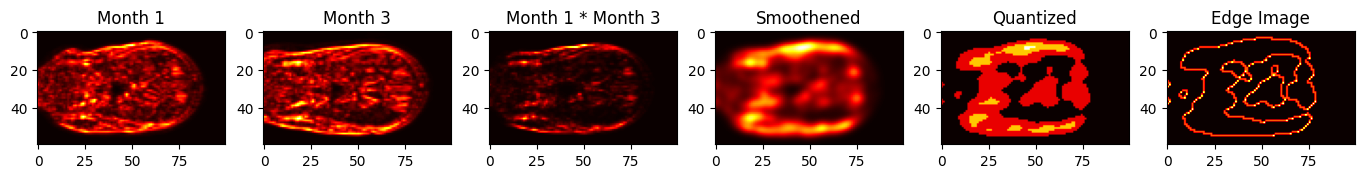

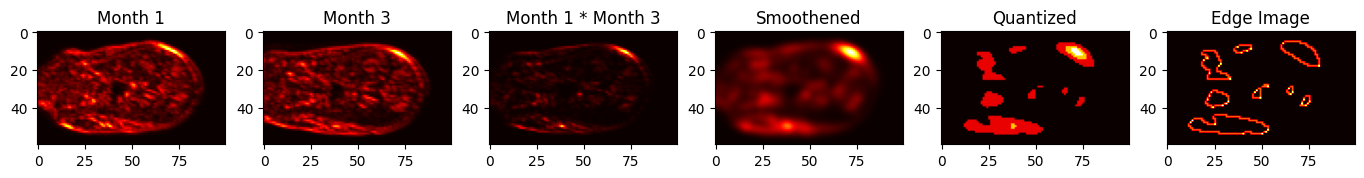

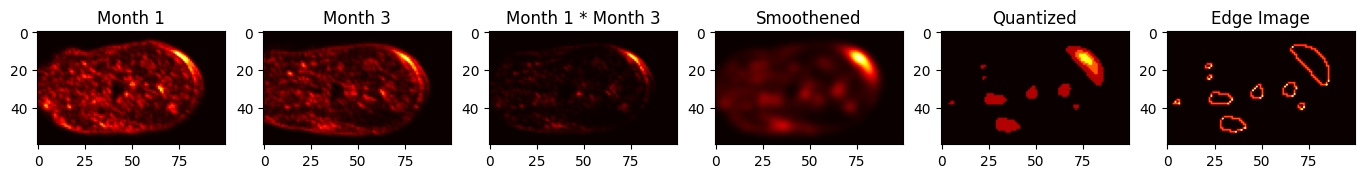

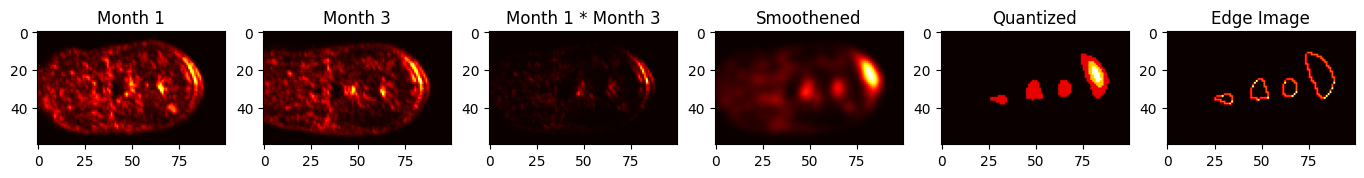

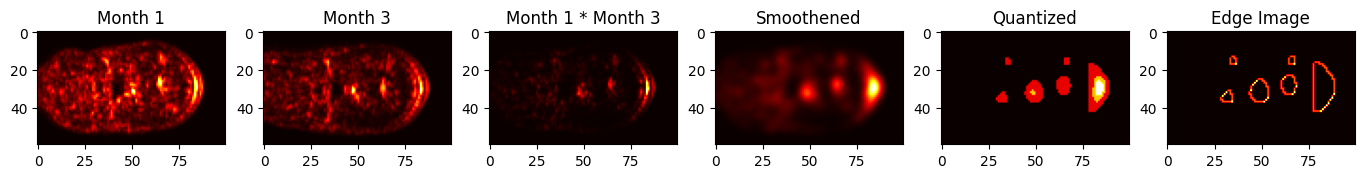

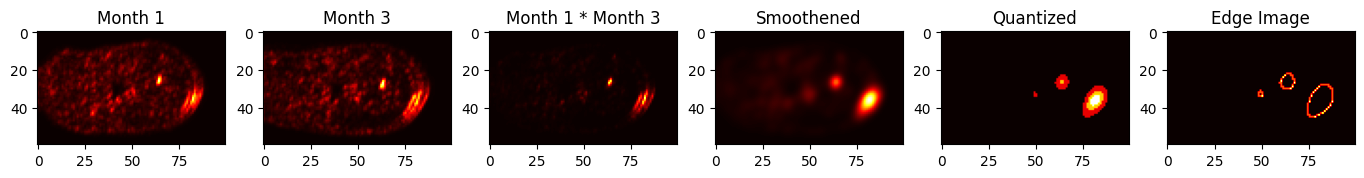

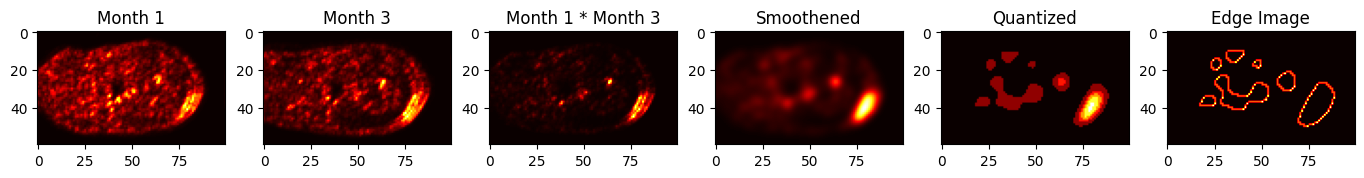

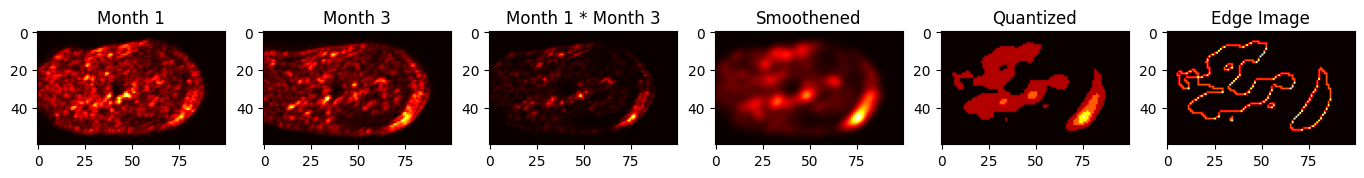

In [64]:
# plot all scattering coefficients
# for i in range(len(scattering_month1)):
for i in range(20):
    fig,ax = plt.subplots(1,6, figsize=(17,5))
    # ax[0].imshow(scattering_month1[i], cmap='hot')
    # ax[0].set_title('Scattering Coefficients Month 1')
    pdt = (scattering_registered_month3[i]*scattering_month1[i]) 
    #pad edge with zeros
    # print(edge.shape)

    ax[0].imshow(scattering_month1[i], cmap='hot')
    ax[0].set_title('Month 1')
    ax[1].imshow(scattering_registered_month3[i], cmap='hot')
    ax[1].set_title('Month 3')
    # ax[2].imshow((scattering_month1[i]-scattering_registered_month3[i]), cmap='gray')
    #overlay scattering month 1 and month 3
    ax[2].imshow(pdt, cmap='hot', alpha=1)
    # ax[2].imshow(scattering_month1[i], cmap='hot', alpha=0.5)
    ax[2].set_title('Month 1 * Month 3')

    #find edge of pdt
    gpdt = gaussian_filter(pdt, sigma=2)
    edge = np.abs(np.diff((pdt)))
    edge = np.concatenate((edge, edge[:,-1].reshape(-1,1)), axis =1)
    gedge = gaussian_filter(edge, sigma=3)
    
    gedge = np.where(gedge > 0.1*np.max(gedge), gedge, 0)
    
    # ax[3].imshow(np.abs(scattering_registered_month3[i]-gedge/np.max(gedge)*np.max(scattering_registered_month3)), cmap='hot')
    # ax[3].imshow(scattering_registered_month3[i]-(1- gedge/np.max(gedge))*np.mean(scattering_registered_month3[i]), cmap='hot')
    # double_edge = np.abs(np.diff(edge))
    # double_edge = np.concatenate((double_edge, double_edge[:,-1].reshape(-1,1)), axis =1)
    # double_edge = np.where(double_edge > 0.15*np.max(double_edge), double_edge, 0)
    
    guassian_pdt = gaussian_filter((10*pdt/np.max(pdt)),sigma=2)
    quantized_pdt = np.round(guassian_pdt)
    boundary1 = np.abs(np.diff(np.sign(quantized_pdt), axis=1))
    boundary1 = np.concatenate((boundary1, boundary1[:,-1].reshape(-1,1)), axis =1)
    boundary2 = np.abs(np.diff(np.sign(quantized_pdt), axis=0))
    boundary2 = np.concatenate((boundary2, boundary2[-1,:].reshape(1,-1)), axis =0)
    boundary = boundary1 + boundary2
    ax[3].imshow(guassian_pdt, cmap='hot')
    ax[3].set_title('Smoothened') 
    ax[4].imshow(quantized_pdt, cmap='hot')
    ax[4].set_title('Quantized')    
    ax[5].imshow(boundary, cmap='hot')
    ax[5].set_title('Edge Image')
    
    # ax[4].imshow(np.abs(pdt-gpdt), cmap='hot')
    # ax[4].set_title('Edge Image * Month 1 * Month 3')i
    


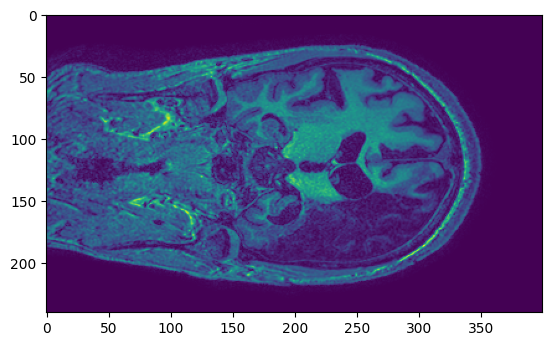

In [35]:
plt.imshow(month3img)